In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Download the Data
Upload your `kaggle.json` file 

In [2]:
!ls


drive  sample_data


In [3]:
!pwd

/content


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/JOVIAN'

In [5]:
!kaggle competitions download -c quora-insincere-questions-classification -f train.csv
!kaggle competitions download -c quora-insincere-questions-classification -f test.csv
!kaggle competitions download -c quora-insincere-questions-classification -f sample_submission.csv

 60% 33.0M/54.9M [00:00<00:00, 66.9MB/s]
100% 54.9M/54.9M [00:00<00:00, 96.6MB/s]
  0% 0.00/15.8M [00:00<?, ?B/s]
100% 15.8M/15.8M [00:00<00:00, 169MB/s]
  0% 0.00/4.09M [00:00<?, ?B/s]
100% 4.09M/4.09M [00:00<00:00, 132MB/s]


In [6]:
train_fname = './train.csv.zip'
test_fname = './test.csv.zip'
sub_fname = './sample_submission.csv.zip'

In [7]:
import pandas as pd

raw_df = pd.read_csv(train_fname)
test_df = pd.read_csv(test_fname)
sub_df = pd.read_csv(sub_fname)

In [13]:
raw_df.shape, test_df.shape, sub_df.shape

((1306122, 3), (375806, 2), (375806, 2))

In [8]:
raw_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
test_df.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [10]:
sub_df.head()

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


#### Taking only a sample of data

In [11]:
sample_df = raw_df.sample(100_000, random_state=42)
sample_df.head()

,qid,question_text,target
443046,56d324bb1e2c29f43b12,What is the most effective classroom managemen...,0
947549,b9ad893dc78c577f8a63,Can I study abroad after 10th class from Bangl...,0
523769,6689ebaeeb65b209a412,How can I make friends as a college junior?,0
949821,ba1e2c4a0fef09671516,How do I download free APK Minecraft: Pocket E...,0
1030397,c9ea2b69bf0d74626f46,"Like Kuvera, is ""Groww"" also a free online inv...",0


In [12]:
sample_df.shape

(100000, 3)

# 2. Prepare Data for Training 
Steps :
- Convert text to TF-IDF Vectors
- Split training & validation set
- Convert to PyTorch tensors

### Conversion to TF-IDF Vectors

In [14]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
####  Texts to tokens 
stemmer = SnowballStemmer(language='english')

def tokenize(text):
  return [stemmer.stem(token) for token in word_tokenize(text)] 

### Stopwords 
english_stopwords = stopwords.words('english')
# list of stopwords
", ".join(english_stopwords) 

### Tf-Idf Vectorizer
vectorizer = TfidfVectorizer(lowercase=True,
                             tokenizer = tokenize,
                             stop_words = english_stopwords,
                             max_features=1000) 


In [19]:
### apply the vectorizer to text
%%time
vectorizer.fit(sample_df.question_text)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CPU times: user 29.4 s, sys: 60 ms, total: 29.4 s
Wall time: 29.5 s


TfidfVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize at 0x7f7254210a60>)

In [20]:
### How does the features look ?
vectorizer.get_feature_names_out()[:100]

array(['!', '$', '%', '&', "'", "''", "'m", "'s", '(', ')', ',', '-', '.',
       '1', '10', '100', '12', '12th', '15', '2', '20', '2017', '2018',
       '3', '4', '5', '6', '7', '8', ':', '?', '[', ']', '``', 'abl',
       'abroad', 'abus', 'accept', 'access', 'accomplish', 'accord',
       'account', 'achiev', 'act', 'action', 'activ', 'actor', 'actual',
       'ad', 'add', 'address', 'admiss', 'adult', 'advanc', 'advantag',
       'advic', 'affect', 'africa', 'african', 'age', 'agre', 'air',
       'allow', 'almost', 'alon', 'alreadi', 'also', 'altern', 'alway',
       'amazon', 'america', 'american', 'amount', 'analysi', 'android',
       'ani', 'anim', 'anoth', 'answer', 'anxieti', 'anyon', 'anyth',
       'apart', 'app', 'appear', 'appl', 'appli', 'applic', 'approach',
       'arab', 'area', 'armi', 'around', 'art', 'asian', 'ask', 'associ',
       'atheist', 'attack', 'attend'], dtype=object)

#### Transform the features to vectors

In [21]:
inputs = vectorizer.transform(sample_df.question_text)
inputs.shape

(100000, 1000)

In [22]:
targets = sample_df.target
targets.shape

(100000,)

In [23]:
test_inputs = vectorizer.transform(test_df.question_text)
test_inputs.shape

(375806, 1000)

### Split training and validation set

In [24]:
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size=0.3, random_state=42)


In [25]:
train_inputs.shape, val_inputs.shape

((70000, 1000), (30000, 1000))

In [26]:
train_targets.shape, val_targets.shape

((70000,), (30000,))

### Convert to PyTorch Tensors
Pytorch requires to be in its own format which is tensor. Pytorch can also run on gpu.

In [27]:
import torch

In [28]:
### train_inputs is a sparse matrix because it has a bunch of zeroes, 
### we shall convert it into a numpy array by ".toarray". We also need to convert this into floating point tensors 

train_input_tensors = torch.tensor(train_inputs.toarray()).float()
val_input_tensors = torch.tensor(val_inputs.toarray()).float()

In [29]:
train_input_tensors.shape, val_input_tensors.shape

(torch.Size([70000, 1000]), torch.Size([30000, 1000]))

In [30]:
### train_targets is panda series but we need numpy array
train_target_tensors = torch.tensor(train_targets.values)
val_target_tensors = torch.tensor(val_targets.values)

In [31]:
test_input_tensors = torch.tensor(test_inputs.toarray()).float()

## 3. Create PyTorch DataLoaders 
Because Deep learning models are large models we often have to train our models not using the entire dataset but using a batch of the data. Pytorch enables you to create something with DataLoader. It cannot process all the data at once,so we split data into batches, each batch has a certain size. This batching is done with the help of dataloader.

In [32]:
from torch.utils.data import TensorDataset, DataLoader

In [33]:
### we create a dataset, which contains both inputs and targets together because 
### when we split the data into batches we want to make sure that inputs and targets are together. 

train_ds = TensorDataset(train_input_tensors, train_target_tensors)
val_ds = TensorDataset(val_input_tensors, val_target_tensors)

test_ds = TensorDataset(test_input_tensors)

In [34]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [35]:
for batch in train_dl:
   batch_inputs = batch[0]
   batch_targets = batch[1]
   print('batch_inputs.shape', batch_inputs.shape)
   print('batch_targets.shape', batch_targets.shape)
   break

batch_inputs.shape torch.Size([128, 1000])
batch_targets.shape torch.Size([128])


In [36]:
len(train_dl)

547

# 4. Train Deep Learning model

In [37]:
import torch.nn as nn
import torch.nn.functional as F

In the class below, we define two functions, first is the "init" function where we setup the layers of the model and another is the "forward" function taking batch of inputs and returning batch of outputs. 

##### With Tf-idf we had got 1000 inputs as vectors so we start with the same value here. Layer 1 will reduce the 1000 inputs to 512 inputs, then layer 2 will reduce 512 to 256 and subsequently with all the layers. The final output should return only 1 output. 


###### The next function defines what happens when an input is passed through the model. We pass inputs into layer1 and it will give us the output. Then after each layer we need apply a non-linearity, which is "relu" in this case or relu activation. 

In [38]:
class QuoraNET(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(1000, 512)
    self.layer2 = nn.Linear(512, 256)
    self.layer3 = nn.Linear(256, 128)
    self.layer4 = nn.Linear(128, 1)

  def forward(self, inputs):
    out = self.layer1(inputs)
    out = F.relu(out)
    out = self.layer2(out)
    out = F.relu(out)
    out = self.layer3(out)
    out = F.relu(out)
    out = self.layer4(out)
    return out

In [39]:
model = QuoraNET()

In [40]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

for batch in train_dl:
  bi, bt = batch
  print('inputs.shape', bi.shape)
  print('targets.shape', bt.shape)

  bo = model(bi)
  print('bo.shape', bo.shape)

  ### convert outputs to probabilities
  probs = torch.sigmoid(bo[:, 0])
  print('probs', probs[:10])

  ### convert probabilities to predictions
  preds = (probs > 0.5).int()
  print('preds', preds[:10])
  print('targets', bt[:10])

  ### metrics
  print('accuracy', accuracy_score(bt, preds))
  print('f1 score', f1_score(bt, preds))

  ### loss
  print('loss', F.binary_cross_entropy(probs, bt.float()))

  break

inputs.shape torch.Size([128, 1000])
targets.shape torch.Size([128])
bo.shape torch.Size([128, 1])
probs tensor([0.5205, 0.5209, 0.5206, 0.5206, 0.5206, 0.5205, 0.5211, 0.5207, 0.5207,
        0.5210], grad_fn=<SliceBackward0>)
preds tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
targets tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
accuracy 0.0234375
f1 score 0.04580152671755725
loss tensor(0.7337, grad_fn=<BinaryCrossEntropyBackward0>)


##### Impact of class weight
In our case, 94% of the data has the target value as 0, and class 1 is present only in 6% of the data, so while computing the loss we might want to give a higher weight the value 1. We want our model to pay more attention to predict the value 1 correctly. So we make a change in the "evaluate" function (weight = torch.tensor())

we need to give importance to both the classes so what if for each data point with class 1 we give weight of 20

In [44]:
### Evaluate model performance
def evaluate(model,dl):
  losses, accs, f1s = [], [], []
  ### loop over batches
  for batch in dl:
    # get inputs and targets
    inputs, targets = batch

    # pass inputs through model
    outputs = model(inputs)

    # convert to probabilities
    probs = torch.sigmoid(outputs[:,0])

    # compute loss
    loss = F.binary_cross_entropy(probs, targets.float(), weight = torch.tensor(20.))

    # compute preds
    preds = (probs > 0.5).int()

    # compute accuracy & f1 score
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)

    losses.append(loss)
    accs.append(acc)
    f1s.append(f1)

  return (torch.mean(torch.tensor(losses)).item(), 
  torch.mean(torch.tensor(accs)).item(), 
  torch.mean(torch.tensor(f1s)).item())

In [42]:
evaluate(model, train_dl)

(14.611950874328613, 0.06022092909375816, 0.1128488266895901)

In [43]:
evaluate(model, val_dl)

(14.611191749572754, 0.06073803191489362, 0.11375188015022651)

# 5. Optimizing to improve the scores

##### Train model batch by batch 
##### Train via epochs where we pass the model multiple times 
##### Performing the back propagation algorithm to improve the weights of the model using Gradient descent 
##### loss.backward : computes the derivative of the loss wrt each individual weight within the model 
##### optimiser.step : we use the derivative or gradient of each weight to slightly adjust each weight 
##### optimiser.zero_grad : with updated weights we need to clear out the gradients for each weight

In [46]:
def fit(epochs, lr, model, train_dl, val_dl):
  history = []
  optimizer = torch.optim.Adam(model.parameters(),lr, weight_decay=1e-5)

  for epoch in range(epochs):
    # Training phase 
    for batch in train_dl:
      # get inputs and targets
      inputs, targets = batch

      # get model outputs
      outputs = model(inputs)

      # get probabilities
      probs = torch.sigmoid(outputs[:,0])

      # compute loss
      loss = F.binary_cross_entropy(probs, targets.float(), weight = torch.tensor(20.))

      # optimisation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

     ### Evaluate 
    loss, acc, f1 = evaluate(model, val_dl)
    print('Epoch {}; Loss: {:.4f}; Accuracy: {:.4f}; F1 score: {:.4f}'.format(
         epoch+1, loss, acc, f1
     ))
    history.append([loss,acc,f1])

  return history


In [47]:
model = QuoraNET()

In [49]:
history=[]
history.append(evaluate(model, val_dl))
history

[(13.533552169799805, 0.9392619680851064, 0.0)]

In [51]:
history += fit(5, 0.01, model, train_dl, val_dl)

Epoch 1; Loss: 3.1019; Accuracy: 0.9432; F1 score: 0.1938
Epoch 2; Loss: 3.0778; Accuracy: 0.9469; F1 score: 0.4096
Epoch 3; Loss: 3.1627; Accuracy: 0.9422; F1 score: 0.4444
Epoch 4; Loss: 3.4940; Accuracy: 0.9443; F1 score: 0.4151
Epoch 5; Loss: 4.9776; Accuracy: 0.9389; F1 score: 0.3928


In [52]:
history += fit(5, 0.0001, model, train_dl, val_dl)

Epoch 1; Loss: 5.5513; Accuracy: 0.9393; F1 score: 0.3921
Epoch 2; Loss: 6.1328; Accuracy: 0.9392; F1 score: 0.3904
Epoch 3; Loss: 6.5852; Accuracy: 0.9383; F1 score: 0.3854
Epoch 4; Loss: 7.0013; Accuracy: 0.9383; F1 score: 0.3817
Epoch 5; Loss: 7.1655; Accuracy: 0.9377; F1 score: 0.3769


In [53]:
losses = [item[0] for item in history]
accs = [item[1] for item in history]
f1s = [item[2] for item in history]

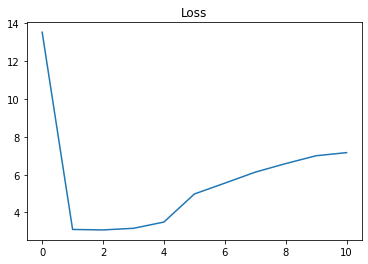

In [54]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(losses)

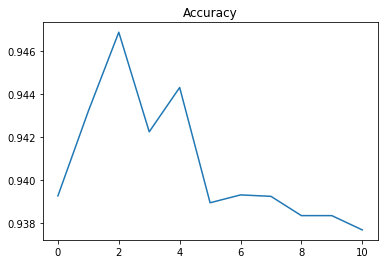

In [55]:
plt.title('Accuracy')
plt.plot(accs)

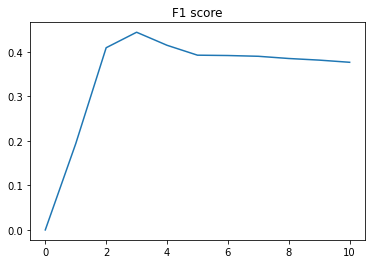

In [56]:
plt.title('F1 score')
plt.plot(f1s)

# 6. Make Predictions 

In [57]:
test_inputs

<375806x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2056612 stored elements in Compressed Sparse Row format>

In [61]:
def predict(model, dl):
    all_preds = []
    for batch in dl:
        inputs, = batch
        out = model(inputs)
        probs = torch.sigmoid(out)[:,0]
        preds = (probs > 0.5).int()
        all_preds += list(preds.numpy())
    return all_preds

In [62]:
test_preds = predict(model, test_dl)

In [63]:
sub_df.prediction = test_preds

In [67]:
sub_df.to_csv('/content/drive/MyDrive/JOVIAN/submission.csv', index=None)

In [66]:
len(sub_df)

375806

In [65]:
sub_df.head(10)

,qid,prediction
0,0000163e3ea7c7a74cd7,0
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0
5,000101884c19f3515c1a,0
6,00010f62537781f44a47,0
7,00012afbd27452239059,0
8,00014894849d00ba98a9,0
9,000156468431f09b3cae,0
